# Model Spacy 1

In [39]:
import spacy
from spacy.tokens import DocBin, Doc
from collections import defaultdict
from pathlib import Path
from spacy.training import Example
import numpy as np
import conllu

In [ ]:
def load_conllu(filepath):
    sentences = []
    current_sentence = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith('#') or line.strip() == "":
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue
            parts = line.split('\t')
            form, upos = parts[1], parts[3]  # FORM = index 1, UPOS = index 3
            current_sentence.append((form, upos))
    return sentences

# Charger les fichiers d'entraînement et de test
train_sentences = load_conllu('fr_sequoia-ud-train.conllu')
test_sentences = load_conllu('fr_sequoia-ud-test.conllu')

In [2]:
def train_spacy_model(train_data, n_iter=20):
    nlp = spacy.blank("fr")  #créer un modèle vide pour le français
    tagger = nlp.add_pipe("tagger")  #un pipeline pour le tagger

    #ajouter les étiquettes (UPOS) au modèle
    for sentence in train_data:
        for _, upos in sentence:
            tagger.add_label(upos)

    #préparer les exemples d'entraînement
    train_examples = []
    for sentence in train_data:
        words = [token[0] for token in sentence]
        tags = [token[1] for token in sentence]
        doc = Doc(nlp.vocab, words=words)
        example = Example.from_dict(doc, {"tags": tags})
        train_examples.append(example)

    #configurer l'optimiseur
    optimizer = nlp.initialize()

    #entraîner le modèle sur plusieurs itérations
    for i in range(n_iter):
        losses = {}
        nlp.update(train_examples, sgd=optimizer, losses=losses)
        print(f"Iteration {i + 1}, Losses: {losses}")

    return nlp

# Entraîner le modèle sur les données d'entraînement
nlp = train_spacy_model(train_sentences)


Iteration 1, Losses: {'tagger': 48811.299599051476}
Iteration 2, Losses: {'tagger': 48461.90775358677}
Iteration 3, Losses: {'tagger': 47802.87590819597}
Iteration 4, Losses: {'tagger': 46732.400437533855}
Iteration 5, Losses: {'tagger': 45203.09264320135}
Iteration 6, Losses: {'tagger': 43237.79304814339}
Iteration 7, Losses: {'tagger': 40939.65230512619}
Iteration 8, Losses: {'tagger': 38398.05596917868}
Iteration 9, Losses: {'tagger': 35666.776502370834}
Iteration 10, Losses: {'tagger': 32806.08341109753}
Iteration 11, Losses: {'tagger': 29927.871662646532}
Iteration 12, Losses: {'tagger': 27204.808541819453}
Iteration 13, Losses: {'tagger': 24768.57587067783}
Iteration 14, Losses: {'tagger': 22693.50382053107}
Iteration 15, Losses: {'tagger': 20980.072894398123}
Iteration 16, Losses: {'tagger': 19514.17832305096}
Iteration 17, Losses: {'tagger': 18154.839920865837}
Iteration 18, Losses: {'tagger': 16846.84522873338}
Iteration 19, Losses: {'tagger': 15617.490646868304}
Iteration 20,

In [10]:
# Enregistrement 
def save_spacy_model(nlp, output_dir):
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print(f"Modèle enregistré dans {output_dir}")

# Exemple d'utilisation après entraînement
save_spacy_model(nlp, './spacy_model/model-1')  # Chemin d'enregistrement du modèle



Modèle enregistré dans spacy_model/model-1


In [20]:
test_sentences = load_conllu('fr_sequoia-ud-test.conllu')
# Evaluation
def evaluate_spacy_model(nlp, test_data):
    true_labels = []
    pred_labels = []
    sentence_accuracy = []
    class_metrics = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})

    for sentence in test_data:
        doc = nlp(" ".join([token[0] for token in sentence]))
        true = [token[1] for token in sentence]
        pred = [token.tag_ for token in doc]
        true_labels.extend(true)
        pred_labels.extend(pred)

        #accuracy par énoncé
        sentence_accuracy.append(int(true == pred))
        
        #TP, FP, FN par classe
        for t, p in zip(true, pred):
            if t == p:
                class_metrics[t]["tp"] += 1
            else:
                class_metrics[t]["fn"] += 1
                class_metrics[p]["fp"] += 1

    #précisions, rappels et F1 pour chaque classe
    for label, metrics in class_metrics.items():
        tp = metrics["tp"]
        fp = metrics["fp"]
        fn = metrics["fn"]
        precision = (tp / (tp + fp) * 100) if (tp + fp) > 0 else 0
        recall = (tp / (tp + fn) * 100) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        print(f"Class {label} - Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1: {f1:.2f}%")
    
    # F1-macro (moyenne des F1 scores par classe)
    f1_macro = np.mean([2 * m["tp"] / (2 * m["tp"] + m["fp"] + m["fn"]) * 100 for m in class_metrics.values()])
    
    # F1-micro (calcul des TP, FP, FN globalement)
    total_tp = sum(m["tp"] for m in class_metrics.values())
    total_fp = sum(m["fp"] for m in class_metrics.values())
    total_fn = sum(m["fn"] for m in class_metrics.values())
    precision_micro = total_tp / (total_tp + total_fp) * 100
    recall_micro = total_tp / (total_tp + total_fn) * 100
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro)
    
    print(f"Sentence accuracy: {np.mean(sentence_accuracy) * 100:.2f}%")
    print(f"F1-macro: {f1_macro:.2f}%")
    print(f"F1-micro: {f1_micro:.2f}%")

#Chargement du modèle et évaluation 
nlp = spacy.load('./spacy_model/model-1')
evaluate_spacy_model(nlp, test_data)


Class PRON - Precision: 50.47%, Recall: 39.27%, F1: 44.17%
Class NOUN - Precision: 41.25%, Recall: 48.40%, F1: 44.54%
Class VERB - Precision: 29.62%, Recall: 39.44%, F1: 33.83%
Class SCONJ - Precision: 36.00%, Recall: 25.47%, F1: 29.83%
Class DET - Precision: 44.98%, Recall: 43.23%, F1: 44.09%
Class ADJ - Precision: 32.46%, Recall: 17.55%, F1: 22.79%
Class PUNCT - Precision: 44.39%, Recall: 54.06%, F1: 48.75%
Class ADV - Precision: 51.26%, Recall: 14.84%, F1: 23.02%
Class NUM - Precision: 57.89%, Recall: 9.05%, F1: 15.66%
Class ADP - Precision: 47.83%, Recall: 47.80%, F1: 47.81%
Class PROPN - Precision: 40.03%, Recall: 53.77%, F1: 45.89%
Class CCONJ - Precision: 36.73%, Recall: 37.56%, F1: 37.14%
Class AUX - Precision: 44.74%, Recall: 39.42%, F1: 41.91%
Class _ - Precision: 37.15%, Recall: 38.71%, F1: 37.91%
Class X - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Class SYM - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Sentence accuracy: 8.11%
F1-macro: 32.33%
F1-micro: 41.96%


In [21]:
def long_sequences(sentences, threshold=29):
    return [sentence for sentence in sentences if len(sentence) > threshold]

long_test_sentences = long_sequences(test_sentences)
print(f"Nombre de séquences longues: {len(long_test_sentences)}")
evaluate_spacy_model(nlp, long_test_sentences)


Nombre de séquences longues: 139
Class PRON - Precision: 46.02%, Recall: 35.68%, F1: 40.20%
Class NOUN - Precision: 36.13%, Recall: 42.79%, F1: 39.18%
Class VERB - Precision: 26.14%, Recall: 37.17%, F1: 30.69%
Class SCONJ - Precision: 31.82%, Recall: 23.73%, F1: 27.18%
Class DET - Precision: 38.66%, Recall: 36.89%, F1: 37.75%
Class ADJ - Precision: 27.22%, Recall: 13.10%, F1: 17.69%
Class PUNCT - Precision: 36.34%, Recall: 45.69%, F1: 40.48%
Class ADV - Precision: 35.29%, Recall: 8.45%, F1: 13.64%
Class NUM - Precision: 45.00%, Recall: 6.67%, F1: 11.61%
Class ADP - Precision: 42.42%, Recall: 42.22%, F1: 42.32%
Class PROPN - Precision: 39.71%, Recall: 44.48%, F1: 41.96%
Class CCONJ - Precision: 26.49%, Recall: 27.78%, F1: 27.12%
Class _ - Precision: 32.34%, Recall: 33.33%, F1: 32.83%
Class AUX - Precision: 38.75%, Recall: 33.88%, F1: 36.15%
Class X - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Class SYM - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Sentence accuracy: 0.00%
F1-macro: 27.43

In [22]:
def find_oov(train_data, test_data):
    train_vocab = set(token[0] for sentence in train_data for token in sentence)
    oov_sentences = []
    for sentence in test_data:
        if any(token[0] not in train_vocab for token in sentence):
            oov_sentences.append(sentence)
    return oov_sentences

oov_test_sentences = find_oov(train_sentences, test_sentences)
print(f"Nombre de séquences avec OOV: {len(oov_test_sentences)}")
evaluate_spacy_model(nlp, oov_test_sentences)


Nombre de séquences avec OOV: 314
Class PRON - Precision: 50.74%, Recall: 37.85%, F1: 43.35%
Class NOUN - Precision: 38.89%, Recall: 46.29%, F1: 42.27%
Class VERB - Precision: 28.51%, Recall: 37.26%, F1: 32.30%
Class SCONJ - Precision: 37.50%, Recall: 26.97%, F1: 31.37%
Class DET - Precision: 43.20%, Recall: 41.63%, F1: 42.40%
Class ADJ - Precision: 29.68%, Recall: 16.00%, F1: 20.79%
Class PUNCT - Precision: 43.02%, Recall: 52.63%, F1: 47.34%
Class ADV - Precision: 46.24%, Recall: 12.15%, F1: 19.24%
Class NUM - Precision: 44.83%, Recall: 6.67%, F1: 11.61%
Class ADP - Precision: 44.83%, Recall: 45.05%, F1: 44.94%
Class PROPN - Precision: 39.05%, Recall: 51.12%, F1: 44.28%
Class CCONJ - Precision: 35.32%, Recall: 36.41%, F1: 35.86%
Class AUX - Precision: 42.80%, Recall: 38.08%, F1: 40.30%
Class _ - Precision: 33.92%, Recall: 35.40%, F1: 34.64%
Class X - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Class SYM - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Sentence accuracy: 3.18%
F1-macro: 30.

# Model Spacy 2
**Réentrainer un modèle pré-entrainé (le transfer-learning)**

In [14]:
!python -m spacy convert ./fr_sequoia-ud-train.conllu ./ --converter conllu
!python -m spacy convert ./fr_sequoia-ud-dev.conllu ./ --converter conllu
!python -m spacy convert ./fr_sequoia-ud-test.conllu ./ --converter conllu
!python -m spacy download fr_core_news_md
!python -m spacy init config ./base_config.cfg --lang fr --pipeline tagger
!python -m spacy init fill-config ./base_config.cfg ./config.cfg


ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (2231 documents): fr_sequoia-ud-train.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (412 documents): fr_sequoia-ud-dev.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (456 documents): fr_sequoia-ud-test.spacy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 53.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')

✘ The provided output file already exists. To force overwriting the
config file, set the --force or -F flag.

⚠ Nothing to auto-fill: base config is already complete
✔ Saved conf

In [15]:
!python -m spacy train ./config.cfg --output ./spacy_model/ --paths.train ./fr_sequoia-ud-train.spacy --paths.dev ./fr_sequoia-ud-dev.spacy 


ℹ Saving to output directory: spacy_model
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'tagger']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TAGGER  TAG_ACC  SCORE 
---  ------  ------------  -----------  -------  ------
  0       0          0.00        66.37    28.13    0.28
  0     200        138.88      4805.39    89.11    0.89
  0     400        157.22      2291.00    91.64    0.92
  1     600        111.68      1500.52    92.95    0.93
  2     800        103.61      1375.04    93.26    0.93
  3    1000         72.17       946.46    93.54    0.94
  4    1200         48.92       670.30    93.75    0.94
  5    1400         37.94       543.17    93.60    0.94
  7    1600         29.17       437.20    93.91    0.94
  9    1800         20.18       321.55

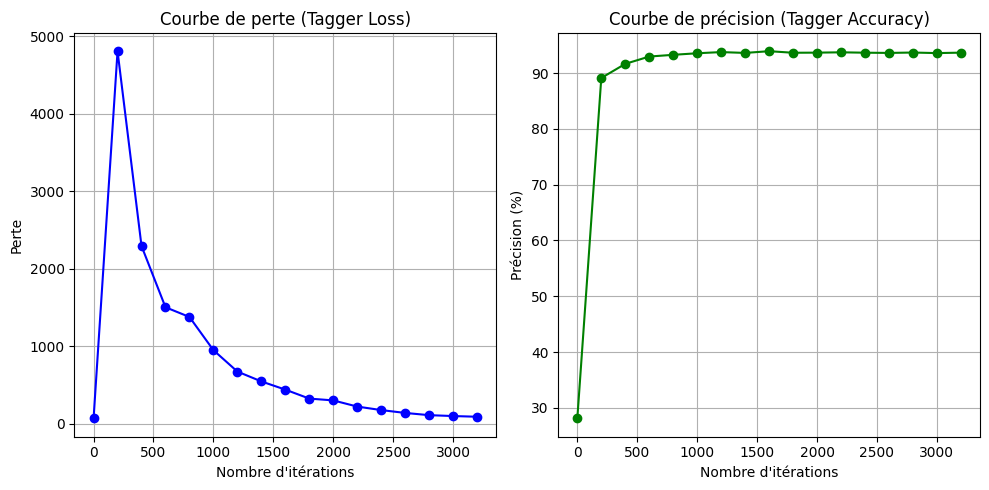

In [37]:
import matplotlib.pyplot as plt

# Données du tableau
epochs = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200]
loss_tagger = [66.37, 4805.39, 2291.00, 1500.52, 1375.04, 946.46, 670.30, 543.17, 437.20, 321.55, 298.18, 218.53, 173.37, 136.41, 107.77, 96.28, 87.30]
tag_acc = [28.13, 89.11, 91.64, 92.95, 93.26, 93.54, 93.75, 93.60, 93.91, 93.63, 93.65, 93.71, 93.64, 93.60, 93.67, 93.57, 93.65]

# Créer le graphique pour la perte
plt.figure(figsize=(10, 5))

# Perte du tagger
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_tagger, marker='o', color='b', label='Loss Tagger')
plt.title('Courbe de perte (Tagger Loss)')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Perte')
plt.grid(True)

# Précision du tagger
plt.subplot(1, 2, 2)
plt.plot(epochs, tag_acc, marker='o', color='g', label='Tag Accuracy')
plt.title('Courbe de précision (Tagger Accuracy)')
plt.xlabel('Nombre d\'itérations')
plt.ylabel('Précision (%)')
plt.grid(True)

plt.tight_layout()
plt.show()


# Explication simple des courbes :
## Courbe de perte (en bleu) :
Au début de l'entraînement, la perte est élevée, ce qui signifie que le modèle fait encore beaucoup d’erreurs.
Rapidement, la perte diminue, ce qui montre que le modèle apprend à mieux prédire les étiquettes.
Après quelques centaines d'itérations, la perte continue de baisser, mais plus lentement, indiquant une amélioration plus progressive.
## Courbe de précision (en vert) :
La précision augmente très vite au début : on passe de 28 % à près de 90 % en quelques itérations.
Ensuite, la courbe se stabilise autour de 93-94 %, montrant que le modèle atteint un bon niveau de performance.

## En résumé :
- Perte : Elle diminue, preuve que le modèle apprend efficacement.
- Précision : Elle grimpe rapidement et se stabilise, montrant que le modèle fonctionne bien et que l'entraînement est sur la bonne voie.

Pour une évaluation complète, il est utile d'inclure les courbes de validation. Cela permet de voir comment le modèle se comporte sur des données qu'il n'a pas rencontrées pendant l'entraînement et d'identifier un potentiel surapprentissage.

In [38]:
# Charger le modèle entraîné depuis le disque
nlp2 = spacy.load('./spacy_model/model-last')
# Évaluer le modèle sur les données de test
evaluate_spacy_model(nlp2, test_data)

Class PRON - Precision: 47.41%, Recall: 49.02%, F1: 48.20%
Class VERB - Precision: 39.15%, Recall: 46.22%, F1: 42.40%
Class SCONJ - Precision: 50.00%, Recall: 39.62%, F1: 44.21%
Class DET - Precision: 46.92%, Recall: 42.83%, F1: 44.78%
Class NOUN - Precision: 46.53%, Recall: 51.87%, F1: 49.06%
Class ADJ - Precision: 42.61%, Recall: 46.08%, F1: 44.28%
Class PUNCT - Precision: 45.56%, Recall: 53.04%, F1: 49.02%
Class ADV - Precision: 51.33%, Recall: 46.96%, F1: 49.05%
Class NUM - Precision: 56.18%, Recall: 58.02%, F1: 57.09%
Class ADP - Precision: 49.83%, Recall: 45.53%, F1: 47.59%
Class PROPN - Precision: 56.67%, Recall: 57.74%, F1: 57.20%
Class CCONJ - Precision: 39.30%, Recall: 40.72%, F1: 40.00%
Class AUX - Precision: 52.14%, Recall: 53.04%, F1: 52.59%
Class _ - Precision: 0.00%, Recall: 0.00%, F1: 0.00%
Class X - Precision: 83.33%, Recall: 27.78%, F1: 41.67%
Class SYM - Precision: 100.00%, Recall: 50.00%, F1: 66.67%
Sentence accuracy: 25.00%
F1-macro: 45.86%
F1-micro: 47.05%
